In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re


import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import utils
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-12-06 22:36:17.940741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 22:36:17.940771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 22:36:17.941921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 22:36:17.948693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 22:36:19.615724: W tensorflow/comp

# check sampling and labeling progress

In [5]:
# sampled in rna-sample-092324.ipynb and labeled
# last checked 10.18 6p
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-cdbas-101524-9.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

for name, thing in name2designdata.items():
    print(name, '{:.4f}'.format(np.mean(thing[1])) if thing[1] is not None else None)

cbas-ridge-0.1 0.2948
cbas-ridge-0.2 0.3003
cbas-ridge-0.3 0.3033
cbas-ridge-0.4 0.3075
cbas-ridge-0.5 0.3121
cbas-ridge-0.6 0.3175
cbas-ridge-0.7 0.3290
cbas-ridge-0.8 0.3539
cbas-ridge-0.9 0.4013
dbas-ridge-0.1 0.3294
dbas-ridge-0.2 0.3921
cbas-ff-0.1 0.2885
cbas-ff-0.2 0.2884
cbas-ff-0.3 0.2900
cbas-ff-0.4 0.2898
cbas-ff-0.5 0.2884
cbas-ff-0.6 0.2882
cbas-ff-0.7 0.2907
cbas-ff-0.8 0.2894
cbas-ff-0.9 0.2930
dbas-ff-0.1 0.3009
dbas-ff-0.2 0.3041
dbas-ff-0.3 0.3016
dbas-ff-0.4 0.3019
dbas-ff-0.5 0.3321
dbas-ff-0.6 0.3333
dbas-ff-0.7 0.3257
dbas-ff-0.8 0.3125
dbas-ff-0.9 0.3288
cbas-cnn-0.1 0.2913
cbas-cnn-0.2 0.2912
cbas-cnn-0.3 0.2907
cbas-cnn-0.4 0.2895
cbas-cnn-0.5 0.2917
cbas-cnn-0.6 0.2914
cbas-cnn-0.7 0.2918
cbas-cnn-0.8 0.2910
cbas-cnn-0.9 0.2917
dbas-cnn-0.1 0.3109
dbas-cnn-0.2 0.3065
dbas-cnn-0.3 0.3096
dbas-cnn-0.4 0.3194
dbas-cnn-0.5 0.3138
dbas-cnn-0.6 0.3187
dbas-cnn-0.7 0.3293
dbas-cnn-0.8 0.3347
dbas-cnn-0.9 0.3394
vae-ridge 0.2853


# plot

In [46]:
# load design names to test (copy from rna-selection-092424.ipynb)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

pp_design_names = ['vae-ridge']
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'cbas-ridge-{q}t19')
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        pp_design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        pp_design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    pp_design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'dbas-{model_name}-{q}')

In [49]:
# load PP and CP selection results, computed in rna-selection-092424
reload(utils)

pp_target_values = np.arange(0.25, 0.501, 0.003)
n_pp_trial = 200
print_worst = True
pp_results_csv_fname = '/data/wongfanc/rna-results/selection-pp-120524.csv'
cp_results_csv_fname = '/data/wongfanc/rna-results/selection-cp-120524.csv'
pp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-pp-120524-truemeans.pkl'

# load CP selection results
cp_df = pd.read_csv(cp_results_csv_fname, index_col=0)
# assert -np.inf LBs in all cases (but if not all trials done, unfilled cells are nan)
print(np.unique(cp_df.to_numpy()))

# load PP selection results and true means
pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
with open(pp_truemeans_pkl_fname, 'rb') as f:
    pp_name2truemeans = pickle.load(f)

# process for plotting
ppworst_v, pperr_v, ppdisc_v, ppval2configs = utils.process_rna_selection_experiments(
    pp_df, pp_target_values, pp_design_names, pp_name2truemeans, n_pp_trial,
    imp_or_pp='pp', alpha=0.1, print_worst=print_worst
)

[-inf]
Processing pp results with the following menu of size 78, 84 target values in [0.25, 0.50], 200 trials, and alpha = 0.1:
  vae-ridge
  cbas-ridge-0.1t19
  cbas-ridge-0.2t19
  cbas-ridge-0.3t19
  cbas-ridge-0.4t19
  cbas-ridge-0.5t19
  cbas-ridge-0.6t19
  cbas-ridge-0.7t19
  cbas-ridge-0.8t19
  cbas-ridge-0.9t19
  dbas-ridge-0.1t19
  dbas-ridge-0.2t19
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
  dbas-ff-0.7
  dbas-ff-0.8
  dbas-ff-0.9
  adalead-cnn-0.2
  adal

  target value 0.3310, trial 124, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 145, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 157, is biswas-ff-0.02 with true mean label of 0.3238
  target value 0.3310, trial 168, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 169, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 173, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 182, is biswas-ff-0.02 with true mean label of 0.3238
  target value 0.3310, trial 183, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3310, trial 186, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3340, trial 9, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3340, trial 12, is biswas-ridge-0.02 with true mean label of 0.3261
  target value 0.3340, trial 14, is biswas-ridge-0.02 with true

  target value 0.3400, trial 168, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 169, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 173, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 174, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 175, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 182, is biswas-ff-0.015 with true mean label of 0.3341
  target value 0.3400, trial 183, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 185, is biswas-ff-0.015 with true mean label of 0.3341
  target value 0.3400, trial 186, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3400, trial 194, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3430, trial 11, is biswas-ridge-0.015 with true mean label of 0.3362
  target value 0.3430, trial 12, is biswas-ridge-0

  target value 0.3550, trial 97, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 104, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 105, is biswas-ff-0.01 with true mean label of 0.3506
  target value 0.3550, trial 115, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 119, is biswas-ff-0.01 with true mean label of 0.3506
  target value 0.3550, trial 124, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 126, is biswas-ff-0.01 with true mean label of 0.3506
  target value 0.3550, trial 133, is biswas-ff-0.01 with true mean label of 0.3506
  target value 0.3550, trial 135, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 138, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3550, trial 153, is biswas-ff-0.01 with true mean label of 0.3506
  target value 0.3550, trial 157, is biswas-ff-0.01 with true mean lab

  target value 0.3610, trial 97, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 104, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 124, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 135, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 138, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 157, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 164, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 168, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 169, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 173, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 177, is biswas-ridge-0.01 with true mean label of 0.3528
  target value 0.3610, trial 182, is biswas-ff-0.01 wit

  target value 0.3700, trial 18, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 21, is adalead-ff-0.2 with true mean label of 0.3698
  target value 0.3700, trial 22, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 24, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 26, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 29, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 30, is adalead-ff-0.2 with true mean label of 0.3698
  target value 0.3700, trial 31, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 32, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 37, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 40, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3700, trial 42, is adalead-ridge-0.2 with true mean la

  target value 0.3730, trial 76, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 79, is biswas-ff-0.005 with true mean label of 0.3718
  target value 0.3730, trial 81, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 83, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 85, is biswas-ff-0.005 with true mean label of 0.3718
  target value 0.3730, trial 87, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 88, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 89, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 91, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3730, trial 93, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3730, trial 95, is biswas-ff-0.005 with true mean label of 0.3718
  target value 0.3730, trial 97, is biswas-ff-0.005 with true mean lab

  target value 0.3760, trial 172, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3760, trial 173, is adalead-ff-0.2 with true mean label of 0.3698
  target value 0.3760, trial 174, is biswas-ff-0.005 with true mean label of 0.3718
  target value 0.3760, trial 175, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3760, trial 179, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3760, trial 180, is adalead-ff-0.2 with true mean label of 0.3698
  target value 0.3760, trial 182, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3760, trial 183, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3760, trial 185, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3760, trial 186, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3760, trial 189, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3760, trial 192, is biswas-ridge-0.005 wi

  target value 0.3820, trial 24, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3820, trial 26, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3820, trial 27, is adalead-ff-0.15 with true mean label of 0.3800
  target value 0.3820, trial 29, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3820, trial 32, is adalead-ff-0.15 with true mean label of 0.3800
  target value 0.3820, trial 33, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3820, trial 37, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3820, trial 38, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3820, trial 41, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3820, trial 42, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3820, trial 44, is adalead-ff-0.15 with true mean label of 0.3800
  target value 0.3820, trial 45, is adalead-ridge-0.15 with true me

  target value 0.3850, trial 114, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3850, trial 115, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 118, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3850, trial 119, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 120, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3850, trial 121, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 122, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 123, is biswas-ridge-0.005 with true mean label of 0.3718
  target value 0.3850, trial 126, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 127, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 129, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3850, trial 131, is adalead-ridge-0

  target value 0.3910, trial 8, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3910, trial 9, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3910, trial 10, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3910, trial 11, is adalead-ff-0.1 with true mean label of 0.3858
  target value 0.3910, trial 13, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3910, trial 14, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3910, trial 18, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3910, trial 21, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3910, trial 26, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3910, trial 27, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3910, trial 29, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3910, trial 32, is adalead-ff-0.1 with true mean

  target value 0.3940, trial 63, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.3940, trial 64, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3940, trial 66, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.3940, trial 67, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3940, trial 71, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3940, trial 75, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3940, trial 83, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3940, trial 84, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3940, trial 87, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3940, trial 88, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.3940, trial 89, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3940, trial 90, is adalead-ff-0.1 with true m

  target value 0.3970, trial 127, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.3970, trial 131, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3970, trial 132, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.3970, trial 135, is adalead-ff-0.1 with true mean label of 0.3858
  target value 0.3970, trial 137, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3970, trial 140, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3970, trial 142, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3970, trial 144, is adalead-ridge-0.2 with true mean label of 0.3665
  target value 0.3970, trial 146, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3970, trial 147, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.3970, trial 150, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.3970, trial 155, is adalead-ridge-0

  target value 0.4030, trial 142, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4030, trial 146, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4030, trial 150, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4030, trial 156, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4030, trial 166, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4030, trial 169, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4030, trial 173, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.4030, trial 179, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4030, trial 182, is dbas-ridge-0.2t19 with true mean label of 0.3928
  target value 0.4030, trial 186, is adalead-ridge-0.15 with true mean label of 0.3757
  target value 0.4060, trial 2, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4060, trial 5, is dbas-ridge-0.2t

  target value 0.4090, trial 142, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4090, trial 144, is adalead-ff-0.05 with true mean label of 0.4077
  target value 0.4090, trial 146, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4090, trial 147, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4090, trial 149, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4090, trial 151, is adalead-ridge-0.01 with true mean label of 0.4079
  target value 0.4090, trial 152, is adalead-ridge-0.01 with true mean label of 0.4079
  target value 0.4090, trial 155, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4090, trial 156, is adalead-ridge-0.1 with true mean label of 0.3841
  target value 0.4090, trial 161, is adalead-ridge-0.01 with true mean label of 0.4079
  target value 0.4090, trial 163, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4090, trial 166, is adalead-ridg

  target value 0.4150, trial 182, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4150, trial 190, is adalead-ridge-0.01 with true mean label of 0.4079
  target value 0.4150, trial 193, is adalead-ff-0.05 with true mean label of 0.4077
  target value 0.4150, trial 195, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4150, trial 197, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 2, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 10, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 13, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 16, is adalead-ridge-0.01 with true mean label of 0.4079
  target value 0.4180, trial 36, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 43, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4180, trial 44, is adalead-ridge-0.0

  target value 0.4270, trial 96, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 98, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 100, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 101, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 102, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 115, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 122, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 129, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 132, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 133, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4270, trial 135, is adalead-ridge-0.05 with true mean label of 0.4049
  target value 0.4270, trial 136, is adalead-ridge-0.05

  target value 0.4330, trial 129, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 132, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 133, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 140, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 144, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 145, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 147, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 151, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 153, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 155, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 157, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4330, trial 168, is cbas-ridge-0.9t19

  target value 0.4420, trial 115, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 129, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 132, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 133, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 140, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 144, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 145, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 147, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 151, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 153, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 168, is cbas-ridge-0.9t19 with true mean label of 0.4261
  target value 0.4420, trial 170, is cbas-ridge-0.9t19

In [34]:
# load imputation design names to test

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

imp_design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    imp_design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        imp_design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        imp_design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    imp_design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        imp_design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            imp_design_names.append(f'dbas-{model_name}-{q}')

In [42]:
# load imputation selection results, computed in rna-selection-092424.ipynb
reload(utils)

imp_target_values = np.arange(0.25, 0.501, 0.003)
n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-102124.csv'
imp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-imputation-102124-truemeans.pkl'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
with open(imp_truemeans_pkl_fname, 'rb') as f:
    imp_name2truemeans = pickle.load(f)
    
impworst_v, imperr_v, impdisc_v, impval2configs = utils.process_rna_selection_experiments(
    imp_df, imp_target_values, imp_design_names, imp_name2truemeans, n_imp_trial, imp_or_pp='imp', alpha=0.1
)

Processing imp results with the following menu of size 78, 84 target values in [0.25, 0.50], 10 trials, and alpha = 0.1:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
  dbas-ff-0.7
  dbas-ff-0.8
  dbas-ff-0.9
  adalead-cnn-0.2
  adalead-cnn-0.15
  adalead-cnn-0.1
  adalead

target 0.427, trial 6, worst selected config is adalead-ridge-0.01 with 0.39724140103019406
target 0.427, trial 7, worst selected config is dbas-ridge-0.2 with 0.3815177749285254
target 0.427, trial 8, worst selected config is adalead-ridge-0.01 with 0.39724140103019406
Done processing 60 / 84 target values (1 s)
target 0.43, trial 2, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.43, trial 3, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.43, trial 6, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.43, trial 7, worst selected config is dbas-ridge-0.2 with 0.3815177749285254
target 0.43, trial 8, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.433, trial 2, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.433, trial 3, worst selected config is cbas-ridge-0.9 with 0.4079984479389607
target 0.433, trial 6, worst selected config is cbas-ridge-0.9 with 0.40799844793

In [36]:
# load wheelock results, computed in rna-wheelock-111224.ipynb
reload(utils)
wf_csv_fname = '/data/wongfanc/rna-results/selection-wheelock-ped-111424.csv'
qs = [0, 0.5, 1]
wf_df = pd.read_csv(wf_csv_fname, index_col=0)

wf_type2results = utils.process_wheelock_selection_experiments(
    wf_df, imp_target_values, imp_design_names, imp_name2truemeans, n_imp_trial, qs=qs
)

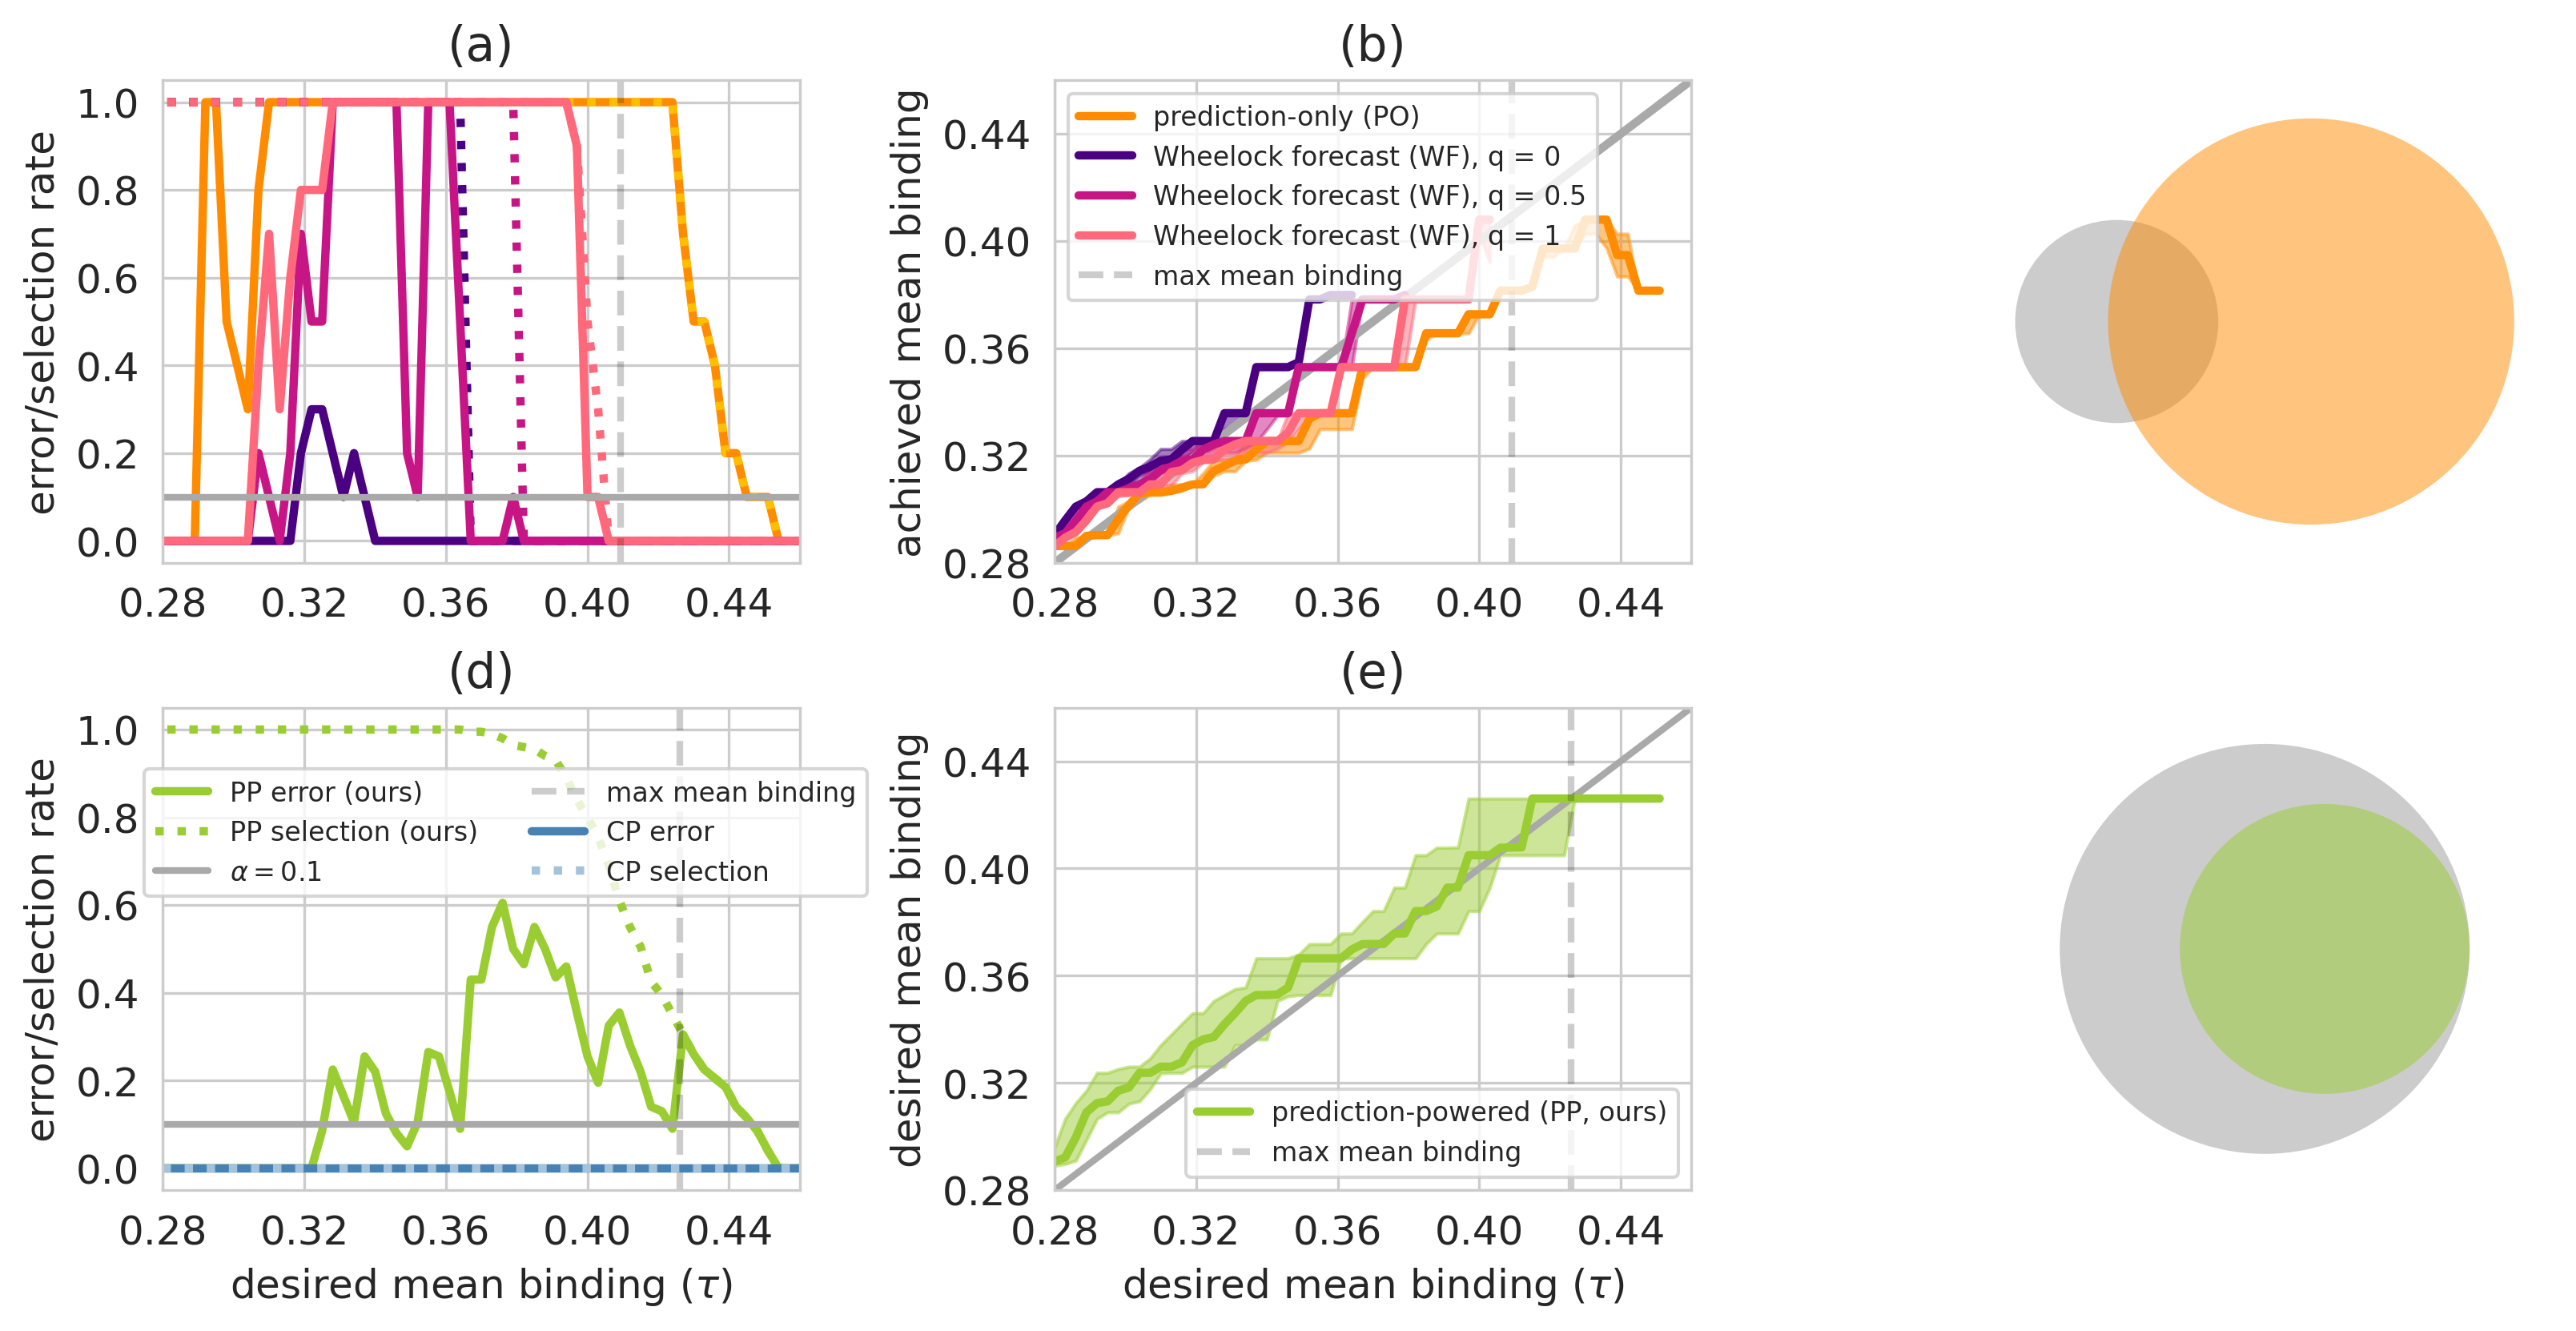

In [50]:
# plot two-row figure
fig, axs = plt.subplots(2, 3, figsize=(13, 6), dpi=300)
ax00 = axs[0, 0]
ax10 = axs[1, 0]
ax01 = axs[0, 1]
ax11 = axs[1, 1]
ax02 = axs[0, 2]
ax12 = axs[1, 2]
fig.subplots_adjust(wspace=0.4, hspace=0.3)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'
lw = 2.5

imp_max_achievable = np.max([np.mean(means_t) for means_t in imp_name2truemeans.values()])
pp_max_achievable = np.max(list(pp_name2truemeans.values()))
imp_xlim = [0.28, 0.46]
imp_xticks = np.arange(0.28, 0.47, 0.04)
pp_xlim = [0.28, 0.46]
pp_xticks = np.arange(0.28, 0.47, 0.04)

# ===== subplots (a, d) =====

ax00.plot(imp_target_values, imperr_v, c=imp_color, linewidth=lw, label='PO error');
ax00.plot(imp_target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw, label='PO selection');
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    _, wferr_v, wfdisc_v, _ = wf_type2results['cs'][q]
    ax00.plot(imp_target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw, label='forecast error');
    ax00.plot(imp_target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw, label='forecast selection');
#     _, wferr_v, wfdisc_v = wf_type2results['no-cs'][q]
#     ax00.plot(imp_target_values, wferr_v, c=wf_nocs_color, alpha=qa, linewidth=lw);
#     ax00.plot(imp_target_values, wfdisc_v, ':', c=wf_nocs_color, alpha=qa, linewidth=lw);

ax00.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax00.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
# ax00.legend(fontsize=8)
ax00.set_ylabel('error/selection rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.05, 0.2))
ax00.set_xlim(imp_xlim)
ax00.set_xticks(imp_xticks)
ax00.set_title('(a)')


ax10.plot(pp_target_values, pperr_v, c=pp_color, linewidth=lw, label='PP error (ours)');
ax10.plot(pp_target_values, ppdisc_v, ':', c=pp_color, linewidth=lw, label='PP selection (ours)');
ax10.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax10.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax10.axhline(0, color='steelblue', linewidth=lw, label='CP error');
ax10.axhline(0, color=(164/255, 195/255, 218/255), linestyle=':', linewidth=lw, label='CP selection');
ax10.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(-0.05, 0.9))
ax10.set_ylabel('error/selection rate');
ax10.set_xlabel(r'desired mean binding ($\tau$)');
ax10.set_ylim([-0.05, 1.05])
ax10.set_yticks(np.arange(0, 1.05, 0.2))
ax10.set_xticks(pp_xticks)
ax10.set_xlim(pp_xlim)
ax10.set_title('(d)')


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    c=dark_line_color, alpha=1, linewidth=lw
);
ax01.plot(
    imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=lw,
)
ax01.fill_between(
    imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    wfworst_v, _, _, _ = wf_type2results['cs'][q]
    ax01.plot(
        imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
        c=wf_colors[q_idx], label=f'Wheelock forecast (WF), q = {q}', linewidth=lw,
    )
    ax01.fill_between(
        imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
        color=wf_colors[q_idx], alpha=0.5,
    )
#     wfworst_v, _, _ = wf_type2results['no-cs'][q]
#     ax01.plot(
#         imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
#         c=wf_nocs_color, alpha=qa, label='Wheelock forecast (WF)', linewidth=lw,
#     )
#     ax01.fill_between(
#         imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
#         [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
#         color=wf_nocs_color, alpha=0.5 * qa,
#     )
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)
ax01.set_title('(b)')

ax11.plot([np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
          [np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
          c=dark_line_color, alpha=1, linewidth=2)
ax11.plot(
    pp_target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=lw,
)
ax11.fill_between(
    pp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax11.legend(fontsize=8)
ax11.set_xlabel(r'desired mean binding ($\tau$)');
ax11.set_ylabel('desired mean binding');
ax11.set_xlim(pp_xlim)
ax11.set_ylim(pp_xlim)
ax11.set_xticks(pp_xticks)
ax11.set_yticks(pp_xticks)
ax11.set_title('(e)')


# ===== subplots (c, f) =====

v = venn2_circles(subsets = (1, 7, 1), ax=ax02);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(imp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

v = venn2_circles(subsets = (1, 0, 1), ax=ax12);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(pp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

# plt.savefig('../figures/gb1-.png')


# find examples for venn diagrams

In [127]:
# construct mapping from target value to 10k configurations that achieve it
imp_val2trueconfigs = {round(val, 4): [] for val in imp_target_values}
for name, means_t in imp_name2truemeans.items():
    for val in imp_target_values:
        val = round(val, 4)
        if np.mean(means_t) >= val:
            if name not in imp_val2trueconfigs[val]:
                imp_val2trueconfigs[val].append(name)
            

In [167]:
# find trials where not all successful configurations are selected,
# for imputation venn diagram
for val in imp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(imp_val2trueconfigs[val])
        for name in trueconfigs:
            for t in range(2):
                selectedconfigs = set(impval2configs[val][t])
                if name not in selectedconfigs:
                    print(val,
                          len(trueconfigs.difference(selectedconfigs)),
                          len(selectedconfigs.difference(trueconfigs)),
                          len(trueconfigs.intersection(selectedconfigs)))
                    print(trueconfigs.difference(selectedconfigs))
                    print(selectedconfigs.difference(trueconfigs))
                    print(trueconfigs.intersection(selectedconfigs))

0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()
0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()


In [148]:
# find trials where not all successful configurations are selected,
# for Wheelock venn diagram
for v, val in enumerate(imp_target_values):
    val = round(val, 4)
    if val >= 0.4:
        
        trueconfigs = set(imp_val2trueconfigs[val])
        
        for t in range(n_imp_trial):
            
            selectedconfigs = set(wf_type2results['cs'][1.][3][val][t])
            
            if len(selectedconfigs):
                print(val, t)
                print(trueconfigs)
                print(selectedconfigs)

0.4 2
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 3
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 6
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 7
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'dbas-ridge-0.2'}
0.4 8
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.403 2
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'cbas-ridge-0.9'}
0.403 3
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'cbas-ridge-0.9'}
0.403 7
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'dbas-ridge-0.2'}


In [147]:
# construct mapping from target value to PP configurations that achieve it
pp_val2trueconfigs = {round(val, 4): [] for val in pp_target_values}
for name, mean in pp_name2truemeans.items():
    for val in pp_target_values:
        val = round(val, 4)
        if mean >= val:
            assert(name not in pp_val2trueconfigs[val])
            pp_val2trueconfigs[val].append(name)
            

In [165]:
# find trials where not all achieving configurations are selected,
# for PP venn diagram
trial_idx = 13
for val in pp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(val2trueconfigs[val])
        selectedconfigs = set(ppval2configs[val][trial_idx])
        
        for name in trueconfigs:
            if name not in selectedconfigs:  # look for when didn't select some successful ones
                print(val,
                      len(trueconfigs.difference(selectedconfigs)),
                      len(selectedconfigs.difference(trueconfigs)),
                      len(trueconfigs.intersection(selectedconfigs)))
                print(trueconfigs.difference(selectedconfigs))
                print(selectedconfigs.difference(trueconfigs))
                print(trueconfigs.intersection(selectedconfigs))

0.402 1 0 1
{'adalead-cnn-0.01'}
set()
{'cbas-ridge-0.9t19'}
0.406 1 1 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19'}
set()
